In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
import time
import re


def get_summary_df(df):
    dfd=df.describe()
    
    tmp=[dfd["mean":"mean"],dfd["max":"max"],dfd["min":"min"],dfd["75%":"75%"]]
    dfx=pd.concat(tmp)
    dfx=dfx.applymap(lambda x:np.round(x,4))
    return dfx

def jobname(x):
    match=re.match(r'.*cern.ch/([\w|\d]+)\|NEWMOVER.*',x)
    if match:
        return match.group(1)
    else:
        return x
l=time.localtime()[0:3]
today="/".join(map(str,l))

df_boinc=pd.read_csv("boinc_job.csv")
df_panda=pd.read_csv("panda_job.csv")
jobs_boinc=df_boinc["name"].count()
jobs_panda=df_panda["name"].count()
print("%d boinc_jobs, %d panda_jobs"%(jobs_boinc,jobs_panda))
del df_boinc["host"]
del df_panda["host"]
df_panda["name"]=df_panda["name"].map(jobname)
df=df_boinc.merge(df_panda,on="name",how="inner")
#print(df.describe())
del df["name"]
df["av"]=df["av"].map(lambda x: "native" if x==478 else "vm")
#print(df.describe())
jobs_total=df["av"].count()
jobs_native=df[df["av"]=="native"].count()["av"]
jobs_vm=df[df["av"]=="vm"].count()["av"]
print("before trimming, %d total jobs, %d vm jobs, %d native jobs"%(jobs_total,jobs_vm,jobs_native))

df["boinc_walltime"]=df["boinc_walltime"]*df["ncore"]
df["cpu_diff"]=df["boinc_cputime"]-df["panda_cputime"]
df["wall_diff"]=df["boinc_walltime"]-df["panda_walltime"]-df["cpu_diff"]
df=df[(df["cpu_diff"]>0) & (df["cpu_diff"]<3600)]
df=df[(df["wall_diff"]>0) & (df["wall_diff"]<3600)]

df["boinc_cpu_eff"]=df["boinc_cputime"]/df["boinc_walltime"]
df["job_cpu_eff"]=df["panda_cputime"]/df["boinc_walltime"]
df["cpu_eff_diff"]=df["panda_cpu_eff"]-df["job_cpu_eff"]
df=df[df["cpu_eff_diff"]>0]
#df=df[df["panda_cpu_eff"]>0.5]

#df=df[df["cpu_eff_diff"]<0.4/df["ncore"]]


df["walltime"]=df["panda_walltime"]/(df["ncore"]*600)
df["walltime"]=df["walltime"].map(int)
df["walltime"]=df["walltime"]*10



jobs_total=df["av"].count()
jobs_native=df[df["av"]=="native"].count()["av"]
jobs_vm=df[df["av"]=="vm"].count()["av"]
print("after trimming, %d total jobs, %d vm jobs, %d native jobs"%(jobs_total,jobs_vm,jobs_native))






308795 boinc_jobs, 406166 panda_jobs
before trimming, 262303 total jobs, 43994 vm jobs, 218309 native jobs
after trimming, 161288 total jobs, 7242 vm jobs, 154046 native jobs


In [10]:
grouped=df.groupby(["av","walltime"])
head=["walltime","av","panda_cpu_eff","job_cpu_eff","cpu_eff_diff","wall_diff","sample_size"]
dlist=[]
for name,group in grouped:
    g=group[["panda_cpu_eff","job_cpu_eff","cpu_eff_diff","cpu_diff","wall_diff"]].mean()
    cn=group["panda_cpu_eff"].count()
    d=[]
    for i in name:
        if i not in ["vm","native"]:
            walltime=i
        else:
            type=i
    d=[walltime,type,g["panda_cpu_eff"],g["job_cpu_eff"],g["cpu_eff_diff"],g["wall_diff"],cn]
    dlist.append(d)
df2=pd.DataFrame(dlist,columns=head)
df2.sort_values(by=["walltime"])
df2=df2[df2["sample_size"]>10]

#df2=df2.set_index("walltime")

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

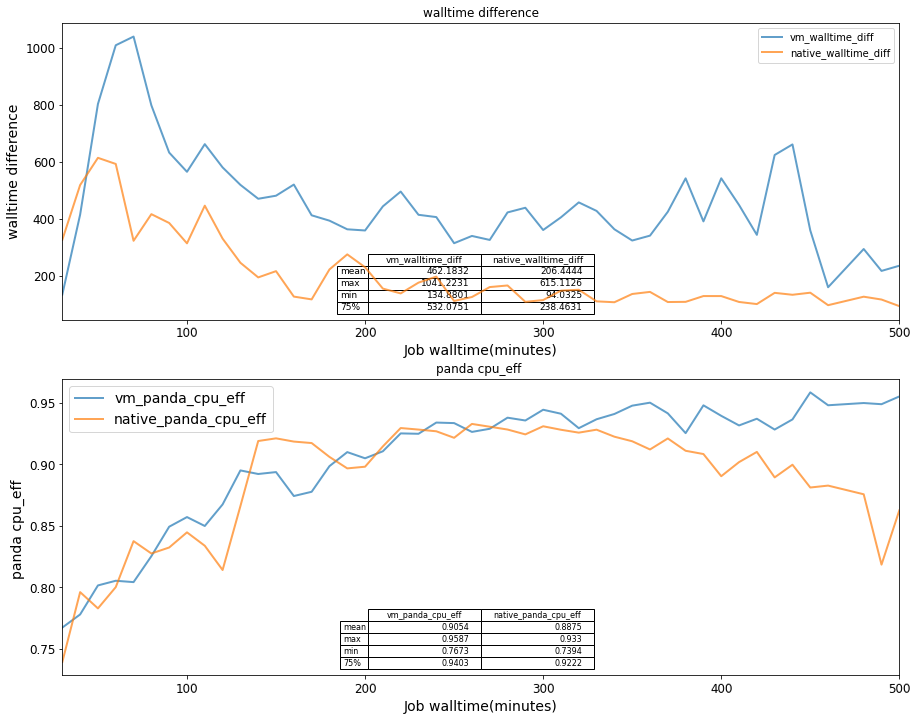

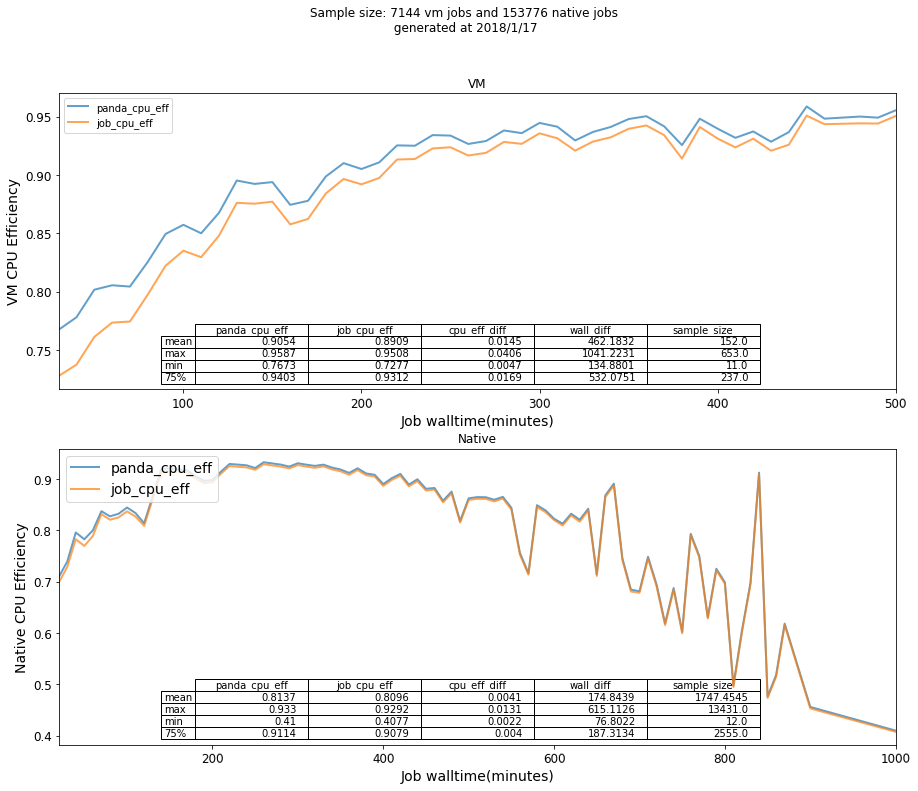

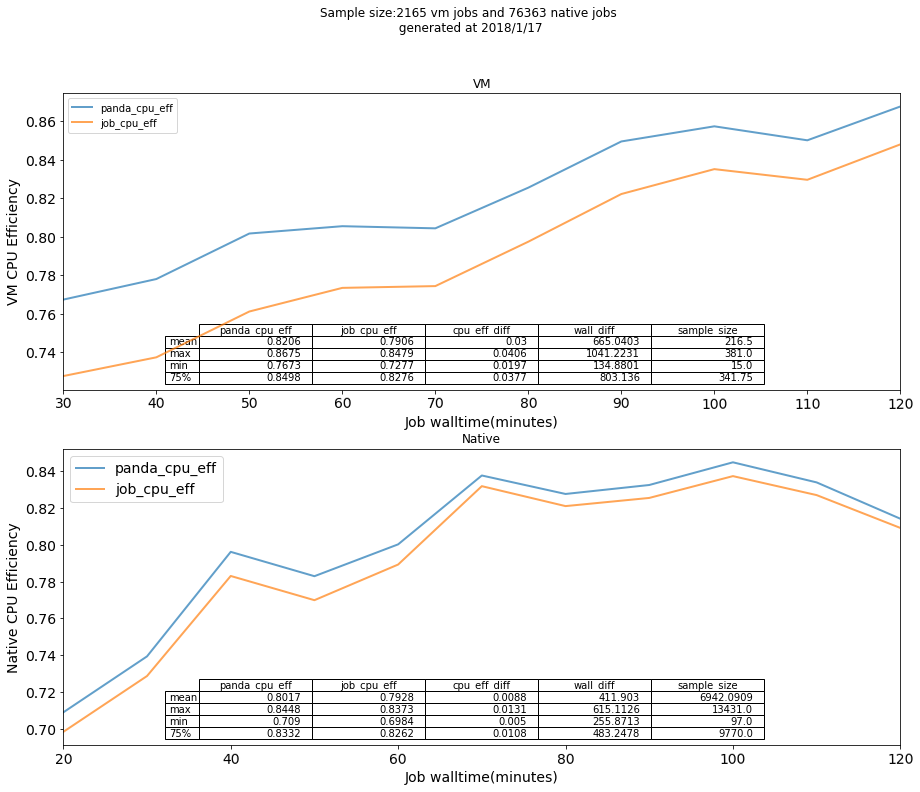

In [11]:

df_vm=df2[df2["av"]=="vm"]
df_native=df2[df2["av"]=="native"]

df_merge=df_vm.merge(df_native,on="walltime")
#df_wd=df_merge[df_merge["walltime"]>40]
df_wd=df_merge[["walltime","wall_diff_x","wall_diff_y","panda_cpu_eff_x","panda_cpu_eff_y"]]
df_wd["vm_walltime_diff"]=df_wd["wall_diff_x"]
df_wd["native_walltime_diff"]=df_wd["wall_diff_y"]
df_wd["vm_panda_cpu_eff"]=df_wd["panda_cpu_eff_x"]
df_wd["native_panda_cpu_eff"]=df_wd["panda_cpu_eff_y"]
del df_wd["wall_diff_x"]
del df_wd["wall_diff_y"]
del df_wd["panda_cpu_eff_x"]
del df_wd["panda_cpu_eff_y"]

df_wd=df_wd.set_index("walltime")
df_wd=df_wd.sort_index()

fig,axes = plt.subplots(2,1)
dfes=[df_wd[["vm_walltime_diff","native_walltime_diff"]],df_wd[["vm_panda_cpu_eff","native_panda_cpu_eff"]]]
for i in range(0,2):
    tag="panda cpu_eff "
    if i%2==0:
        tag="walltime difference"
    
    dfes[i].plot(ax=axes[i],kind="line",grid=False,figsize=(15,12),\
                                                    rot=1,fontsize=12,title=tag,alpha=0.7,linewidth=2.0)
    table(axes[i],get_summary_df(dfes[i]),loc="lower center",colWidths=[0.135]*len(dfes[i].columns),fontsize=14)
    axes[i].set_xlabel("Job walltime(minutes)",fontsize=14)
    axes[i].set_ylabel(tag,fontsize=14)
    plt.legend(loc="upper left",fontsize=14)
fig.savefig("native_perf.png")




df_vm_s=df_vm[df_vm["walltime"]<=120]
df_native_s=df_native[df_native["walltime"]<=120]

dfes=[df_vm,df_native]
jobs_vm=df_vm["sample_size"].sum()
jobs_native=df_native["sample_size"].sum()
fig, axes = plt.subplots(2,1)
plt.suptitle("Sample size: %d vm jobs and %d native jobs\n \
generated at %s"%(jobs_vm,jobs_native,today))
for i in range(0,2):
    tag="Native"
    if i%2==0:
        tag="VM"
    dfes[i]=dfes[i].set_index("walltime")
    dfes[i][["panda_cpu_eff","job_cpu_eff"]].plot(ax=axes[i],kind="line",grid=False,figsize=(15,12),\
                                                    rot=1,fontsize=12,title=tag,alpha=0.7,linewidth=2.0)
    table(axes[i],get_summary_df(dfes[i]),loc="lower center",colWidths=[0.135]*len(dfes[i].columns),fontsize=14)
    axes[i].set_xlabel("Job walltime(minutes)",fontsize=14)
    axes[i].set_ylabel("%s CPU Efficiency"%tag,fontsize=14)
    plt.legend(loc="upper left",fontsize=14)
fig.savefig("native_perf.png")



dfes=[df_vm_s,df_native_s]
jobs_vm=df_vm_s["sample_size"].sum()
jobs_native=df_native_s["sample_size"].sum()
fig, axes = plt.subplots(2,1)
plt.suptitle("Sample size:%d vm jobs and %d native jobs\n \
generated at %s"%(jobs_vm,jobs_native,today))
for i in range(0,2):
    
    tag="Native"
    if i%2==0:
        tag="VM"
    dfes[i]=dfes[i].set_index("walltime")
    dfes[i][["panda_cpu_eff","job_cpu_eff"]].plot(ax=axes[i],kind="line",grid=False,figsize=(15,12),\
                                                    rot=1,fontsize=14,title=tag,alpha=0.7,linewidth=2.0)
    table(axes[i],get_summary_df(dfes[i]),loc="lower center",colWidths=[0.135]*len(dfes[i].columns),fontsize=14)
    axes[i].set_xlabel("Job walltime(minutes)",fontsize=14)
    axes[i].set_ylabel("%s CPU Efficiency"%tag,fontsize=14)
    plt.legend(loc="upper left",fontsize=14)
fig.savefig("native_perf_short.png")
